In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import MDAnalysis as mda
from MDAnalysis.analysis.waterdynamics import WaterOrientationalRelaxation as WOR
from scipy.optimize import curve_fit

/home/axel/Software/miniconda3/envs/lammps/lib/python3.7/site-packages/MDAnalysis/analysis/hbonds/hbond_autocorrel.py:52: DeprecationWarning: This module was moved to MDAnalysis.analysis.hydrogenbonds.hbond_autocorrel; hbonds.hbond_autocorrel will be removed in 3.0.0.
  warnings.warn(wmsg, category=DeprecationWarning)


In [2]:
mda_traj = mda.Universe("../1-SPCE_343-H2O/topology.pdb", "../1-SPCE_343-H2O/traj.xyz", dt=0.01) # dt=0.01 ps
mda_traj.dimensions = [21.725, 21.725, 21.725, 90, 90, 90] # PBC box : lx ly lz alpha beta gamma

In [11]:
mda_traj.atoms.names

array(['O', 'H', 'H', ..., 'O', 'H', 'H'], dtype=object)

In [28]:
mda_traj.select_atoms("name O H")

<AtomGroup with 1029 atoms>

In [33]:
WOR_analysis = WOR(mda_traj, "name O H", 0, 1000, 10)
WOR_analysis.run()

  0%|          | 0/1001 [00:00<?, ?it/s]

In [44]:
mda_traj.atoms.names.shape

(1029,)

In [51]:
pO_0 = mda_traj.trajectory[0].positions[mda_traj.atoms.names == "O",:]
pH1_0 = mda_traj.trajectory[0].positions[np.roll(mda_traj.atoms.names == "O",1),:]
pH2_0 = mda_traj.trajectory[0].positions[np.roll(mda_traj.atoms.names == "O",2),:]

In [55]:
u_0 = ((pH1_0+pH2_0)/2)-pO_0

In [57]:
u_0

array([[ 0.2731452 ,  0.44445992,  0.24738002],
       [ 0.5204549 ,  0.23461485, -0.08616957],
       [ 0.06278646,  0.5580206 , -0.13422489],
       ...,
       [ 0.03577852,  0.48844528, -0.30574203],
       [ 0.22545397,  0.48000526,  0.22826052],
       [-0.14030516,  0.3389349 , -0.44584602]], dtype=float32)

In [90]:
all_vec_H2O_dipole = np.zeros((mda_traj.trajectory.n_frames,np.sum(mda_traj.atoms.names == "O"),3))
for t in range(mda_traj.trajectory.n_frames):
    vOH1_t = mda_traj.trajectory[t].positions[np.roll(mda_traj.atoms.names == "O",1),:] - mda_traj.trajectory[t].positions[mda_traj.atoms.names == "O",:]
    vOH2_t = mda_traj.trajectory[t].positions[np.roll(mda_traj.atoms.names == "O",2),:] - mda_traj.trajectory[t].positions[mda_traj.atoms.names == "O",:]
    mda_traj.dimensions[0]
    vOH1_t = ((vOH1_t + mda_traj.dimensions[0]/2 )%mda_traj.dimensions[0] )-(mda_traj.dimensions[0]/2)
    vOH2_t = ((vOH2_t + mda_traj.dimensions[0]/2 )%mda_traj.dimensions[0] )-(mda_traj.dimensions[0]/2)
    dipole_OHH_t = vOH1_t + vOH2_t
    all_vec_H2O_dipole[t,:,0] = dipole_OHH_t[:,0]/np.linalg.norm(dipole_OHH_t,axis=-1)
    all_vec_H2O_dipole[t,:,1] = dipole_OHH_t[:,1]/np.linalg.norm(dipole_OHH_t,axis=-1)
    all_vec_H2O_dipole[t,:,2] = dipole_OHH_t[:,2]/np.linalg.norm(dipole_OHH_t,axis=-1)

In [64]:
prod_0_10 = np.sum(all_vec_H2O_dipole[0,:,:] * all_vec_H2O_dipole[10,:,:], axis=-1)

In [68]:
np.sum(all_vec_H2O_dipole[0,5,:] * all_vec_H2O_dipole[10,5,:])

-0.021621498218223678

In [95]:
prod_0_10.shape

(343,)

In [104]:
def reorientation_P1(mda_object, origin_sep = 100):
    # compute the array at all times (axis = 0), all water molecules (axis = 1), of the normalized dipole vector
    all_vec_H2O_dipole = np.zeros((mda_traj.trajectory.n_frames,np.sum(mda_traj.atoms.names == "O"),3))
    for t in range(mda_traj.trajectory.n_frames):
        vOH1_t = mda_traj.trajectory[t].positions[np.roll(mda_traj.atoms.names == "O",1),:] - mda_traj.trajectory[t].positions[mda_traj.atoms.names == "O",:]
        vOH2_t = mda_traj.trajectory[t].positions[np.roll(mda_traj.atoms.names == "O",2),:] - mda_traj.trajectory[t].positions[mda_traj.atoms.names == "O",:]
        vOH1_t = ((vOH1_t + mda_traj.dimensions[0]/2 )%mda_traj.dimensions[0] )-(mda_traj.dimensions[0]/2)
        vOH2_t = ((vOH2_t + mda_traj.dimensions[0]/2 )%mda_traj.dimensions[0] )-(mda_traj.dimensions[0]/2)
        dipole_OHH_t = vOH1_t + vOH2_t
        all_vec_H2O_dipole[t,:,0] = dipole_OHH_t[:,0]/np.linalg.norm(dipole_OHH_t,axis=-1)
        all_vec_H2O_dipole[t,:,1] = dipole_OHH_t[:,1]/np.linalg.norm(dipole_OHH_t,axis=-1)
        all_vec_H2O_dipole[t,:,2] = dipole_OHH_t[:,2]/np.linalg.norm(dipole_OHH_t,axis=-1)
    
    reorientation_tcf = np.zeros(mda_object.trajectory.n_frames)
    reorientation_tcf_norm = np.zeros(mda_object.trajectory.n_frames)

    for t0 in range(0, mda_object.trajectory.n_frames, origin_sep):
        for t in range(t0,mda_object.trajectory.n_frames):
            # average over all O
            reorientation_tcf[t-t0] += np.mean(np.sum(all_vec_H2O_dipole[t0,:,:] * all_vec_H2O_dipole[t,:,:], axis=-1))
            reorientation_tcf_norm[t-t0] += 1
    
    return reorientation_tcf / reorientation_tcf_norm

In [110]:
def reorientation_P2(mda_object, origin_sep = 100):
    # compute the array at all times (axis = 0), all water molecules (axis = 1), of the normalized dipole vector
    all_vec_H2O_dipole = np.zeros((mda_traj.trajectory.n_frames,np.sum(mda_traj.atoms.names == "O"),3))
    for t in range(mda_traj.trajectory.n_frames):
        vOH1_t = mda_traj.trajectory[t].positions[np.roll(mda_traj.atoms.names == "O",1),:] - mda_traj.trajectory[t].positions[mda_traj.atoms.names == "O",:]
        vOH2_t = mda_traj.trajectory[t].positions[np.roll(mda_traj.atoms.names == "O",2),:] - mda_traj.trajectory[t].positions[mda_traj.atoms.names == "O",:]
        vOH1_t = ((vOH1_t + mda_traj.dimensions[0]/2 )%mda_traj.dimensions[0] )-(mda_traj.dimensions[0]/2)
        vOH2_t = ((vOH2_t + mda_traj.dimensions[0]/2 )%mda_traj.dimensions[0] )-(mda_traj.dimensions[0]/2)
        dipole_OHH_t = vOH1_t + vOH2_t
        all_vec_H2O_dipole[t,:,0] = dipole_OHH_t[:,0]/np.linalg.norm(dipole_OHH_t,axis=-1)
        all_vec_H2O_dipole[t,:,1] = dipole_OHH_t[:,1]/np.linalg.norm(dipole_OHH_t,axis=-1)
        all_vec_H2O_dipole[t,:,2] = dipole_OHH_t[:,2]/np.linalg.norm(dipole_OHH_t,axis=-1)
    
    reorientation_tcf = np.zeros(mda_object.trajectory.n_frames)
    reorientation_tcf_norm = np.zeros(mda_object.trajectory.n_frames)

    for t0 in range(0, mda_object.trajectory.n_frames, origin_sep):
        for t in range(t0,mda_object.trajectory.n_frames):
            # average over all O
            reorientation_tcf[t-t0] += np.mean((3*(np.sum(all_vec_H2O_dipole[t0,:,:] * all_vec_H2O_dipole[t,:,:], axis=-1)**2)-1)/2)
            reorientation_tcf_norm[t-t0] += 1
    
    return reorientation_tcf / reorientation_tcf_norm

def plot_reorientation(tcf, timestep = 0.01):
    """ Plot reorientation TCF """
    time = np.asarray([i*timestep for i in range(len(tcf))])
    
    Fig, ax = plt.subplots(1,1, figsize=(12,8))
    ax.plot(time , tcf, c='tab:blue', ls='-', lw=2)
    #ax.plot(time, f(time, linear_fit[0], linear_fit[1]), c='red', ls='--', lw=1, label=f'D = {linear_fit[0]:.2f} '+r' $\AA{}^2 \cdot ps^{-1}$')
    ax.set_xlabel("Time [ps]", size=18)
    ax.set_ylabel("reorientation TCF", size=18)
    #ax.legend(prop={'size':18}, loc='best')
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.grid()
    plt.axhline(y=0, color='k')
    plt.show()
    return None

In [105]:
reorientation_tcf_P1 = reorientation_P1(mda_traj,100)

In [108]:
reorientation_tcf_P2 = reorientation_P2(mda_traj,100)

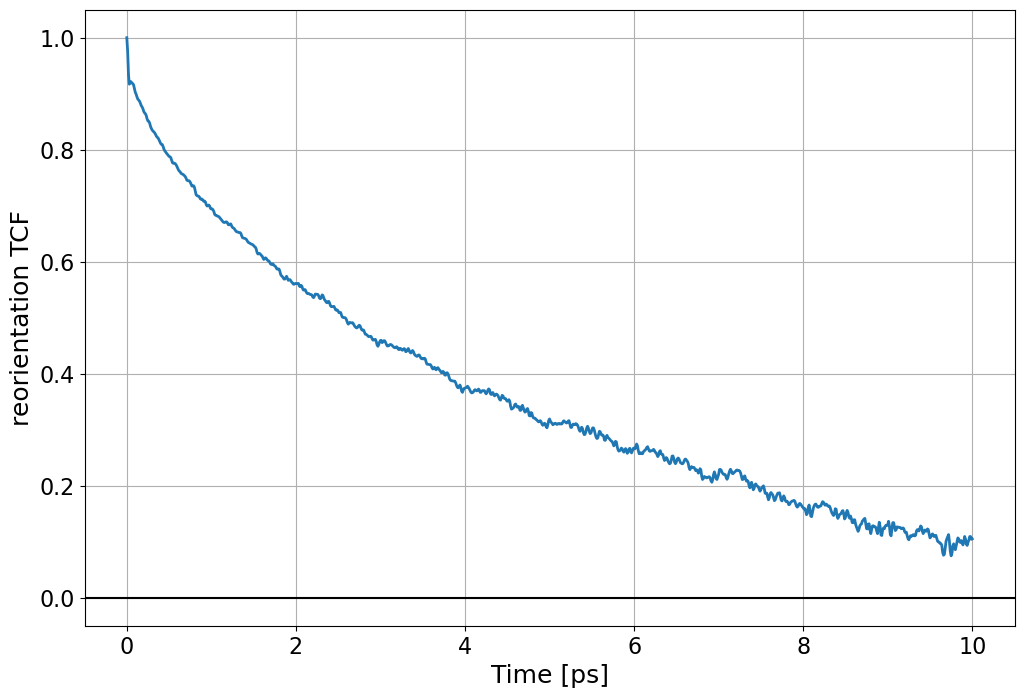

In [111]:
plot_reorientation(reorientation_tcf_P1)

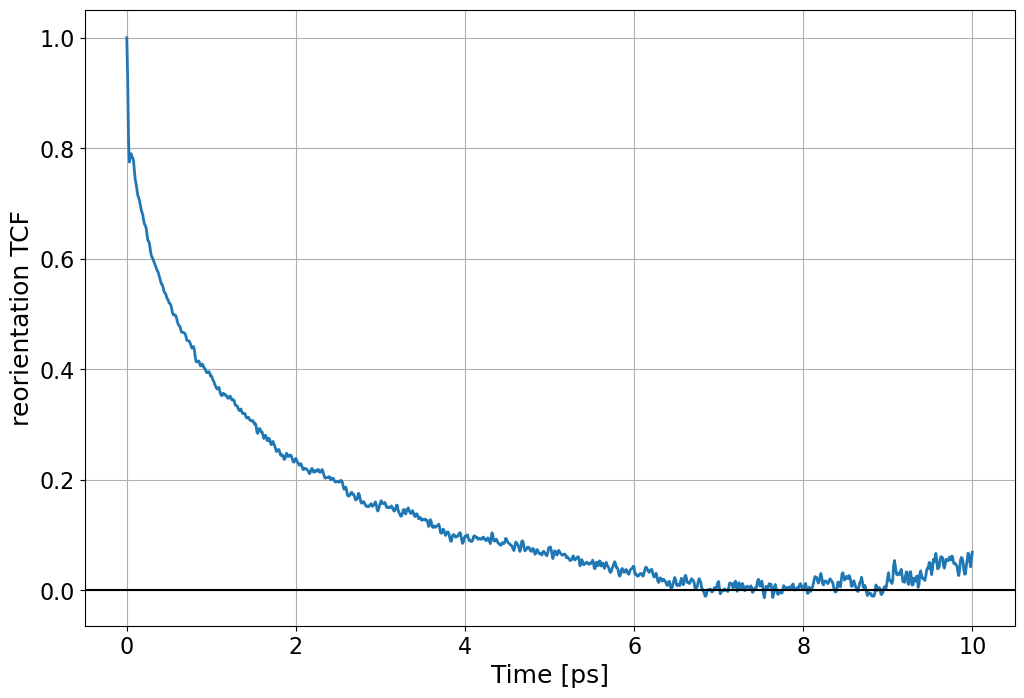

In [112]:
plot_reorientation(reorientation_tcf_P2)

In [34]:
time = 0
#now we print the data ready to plot. The first two columns are WOR_OH vs t plot,
#the second two columns are WOR_HH vs t graph and the third two columns are WOR_dip vs t graph
for WOR_OH, WOR_HH, WOR_dip in WOR_analysis.timeseries:
      print("{time} {WOR_OH} {time} {WOR_HH} {time} {WOR_dip}".format(time=time, WOR_OH=WOR_OH, WOR_HH=WOR_HH,WOR_dip=WOR_dip))
      time += 1

0 0.9384266527488863 0 0.9441833567214444 0 0.9223552874245011
1 0.8371615751058411 1 0.8501139461519746 1 0.8095652236116591
2 0.7778710084037153 2 0.7851875973287514 2 0.7635595960689074
3 0.7687162828866904 3 0.7673864832247022 3 0.7699075921237646
4 0.7784612335032419 4 0.7782406512352814 4 0.7745522437910305
5 0.7820074832061973 5 0.7871434136042017 5 0.7672753873852058
6 0.7779015639732124 6 0.7849723709001792 6 0.7572318711250099
7 0.7655810485650254 7 0.772108510207614 7 0.7476082732786486
8 0.7497130505360525 8 0.7586851687180765 8 0.730668874353481
9 0.7386194902005009 9 0.7464532869887485 9 0.7160682428366667


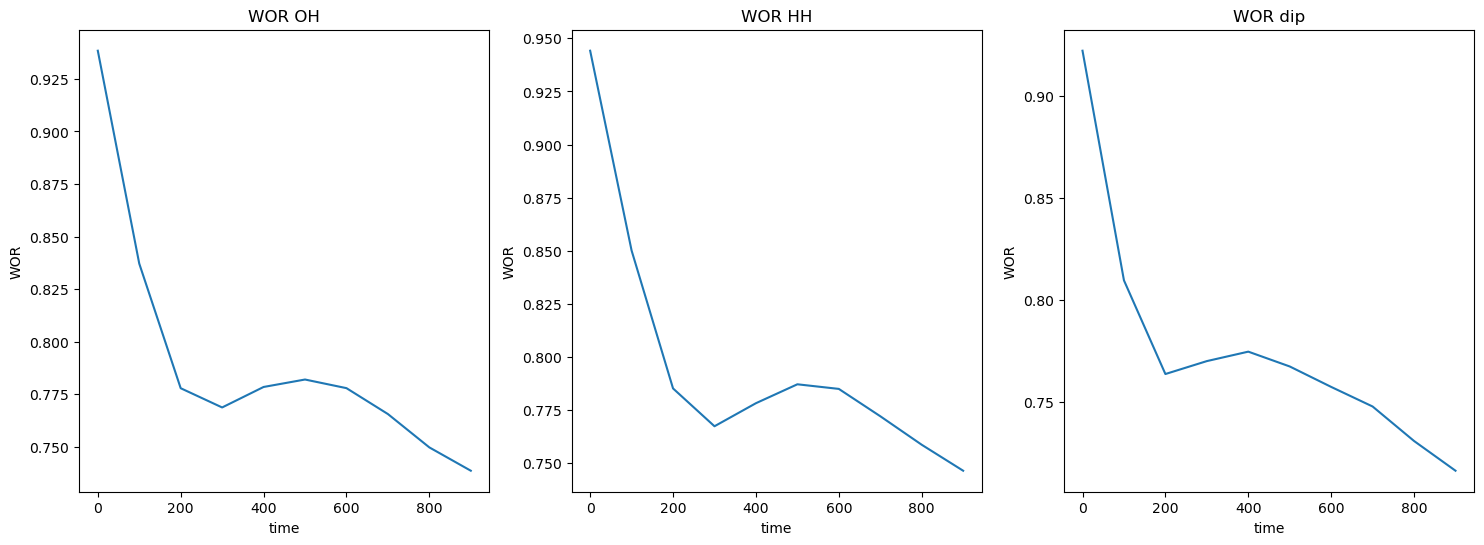

In [39]:
plt.figure(1,figsize=(18, 6))

#WOR OH
plt.subplot(131)
plt.xlabel('time')
plt.ylabel('WOR')
plt.title('WOR OH')
plt.plot(np.arange(0,1000,100),[column[0] for column in WOR_analysis.timeseries])

#WOR HH
plt.subplot(132)
plt.xlabel('time')
plt.ylabel('WOR')
plt.title('WOR HH')
plt.plot(np.arange(0,1000,100),[column[1] for column in WOR_analysis.timeseries])

#WOR dip
plt.subplot(133)
plt.xlabel('time')
plt.ylabel('WOR')
plt.title('WOR dip')
plt.plot(np.arange(0,1000,100),[column[2] for column in WOR_analysis.timeseries])

plt.show()